# GDS to Meep

It is often useful to simulate photonic devices before manufacturing them so that you have some idea of their performance. GDSFactory has a Meep plugin, Gmeep, that can be used to simulate devices using the finite-difference time-domain algorithm (FDTD).

There are several functions within Gmeep that can be used to take a component and turn it into a Meep geometry or simulation. This means that you can take any component, either from GDSFactory or from a GDS file (see the "component_from_gds" notebook), and easily turn it into a Meep geometry. The two most general functions are `get_simulation` and `get_meep_geometry_from_component` (contained within `gmeep.get_simulation.py`). There are other more specific functions to get simulations for a grating coupler with a fiber connected to it, as well as for a far-field simulation for a grating coupler. However, the first two will suffice in this tutorial. Below is some example code showing the use of the functions.

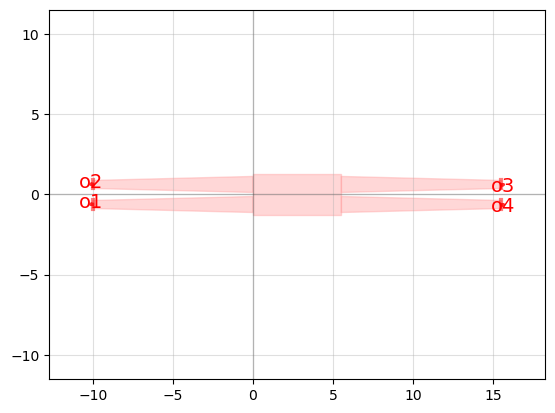

AttributeError: 'Medium' object has no attribute 'lower'

In [37]:
# Code showing examples with a 2x2 MMI for the functions in get_simulation

import gdsfactory as gf
import meep as mp
from gdsfactory.simulation.gmeep.get_simulation import get_simulation, get_meep_geometry_from_component

# Load in the 2x2 MMI from GDSFactory and show layout
c = gf.components.mmi2x2()
c.plot()

# get_meep_geometry_from_component implementation example
get_meep_geometry_from_component(c)

# get_simulation implementation example
sim = get_simulation(component=c,
    resolution=20,
    tpml= 1,
    port_source_offset= 0.2,
    port_monitor_offset= -0.15,
    distance_source_to_monitors= 0.3,
)
sim['sim'].sources = sim['sources']
sim['sim'].cell_size.y = 8
sim['sim'].cell_size.x = 32
sim['sim'].plot2D()
# sim['sim'].run(until=200)

from gdsfactory.simulation.gmeep import write_sparameters_meep

### Finding S-parameters through gmeep

In addition to creating general simulations in Meep, there are several functions in GDSFactory that allow you to find the S-parameters (scattering parameters) of a given component. S-parameters are useful as they tell you how much light is coming in and out of each of the component's port. The most general function for this purpose in Gmeep is `write_sparameters_meep`. 

To use this function, you specify a GDSFactory component, the frequencies you want to test it at, if you would like the simulation to be in 3D, and the margins the simulation needs to take into account. Another useful kwarg for this function is "run". By setting this to `False`, the function plots the simulation geometry instead of running it. So, you can check that the geometry is correct before you waste time simulating it.This is especially important when running the simulation in 3D, as sometimes your geometry may be converted incorrectly from 2D.This is not a comprehensive list of the arguments and is only intended to give a general idea of how the function is used.

The function returns a dictionary of s-parameters. The keys take the form of `"o1@0,o2@0"`, where the first part of the key refers to what port the light is coming from and the second refers to where it is going. For however many ports you have in your component, there will be a key corresponding to the s-parameter from that port to every other port.

Since the relationship between some ports can be the same (i.e. the component may be symmetric), port symmetries can be specified as a keyword argument (kwarg) (`port_symmetries`). This argument takes a dictionary where you specify one s-parameter as the key, and assign as its values the other s-parameters that correspond to it. For example, if you had a 1x2 splitter, where the 2 output ports were symmetric and labeled ports 2 and 3, then you could assign:

```port_symmetries = {"o2@0,o1@0": ["o3@0,o1@0"]}```

 so that the s-parameter for port 2 to 1 will be computed, but the one for port 3 to 1 will not be and will be written with the s-parameter for port 2 to 1. Thus, you save on computation time.

In addition to this general function, Gmeep also has two functions that can be used to write the s-parameters using parallel processing. These are `write_sparamters_meep_mpi` and `write_sparameters_meep_batch`. `write_sparamters_meep_mpi` has you specify how many cores you want to use as a kwarg. `write_sparameters_meep_batch` takes it a step further and runs multiple simulations in parallel, instead of just one. So, you must specify the number of cores per run in addition to the total number of cores to use.

`write_sparameters_grating` is a more specific instance that can be used to find the s-parameters for a grating coupler with an attached fiber. To plot the set up of this, you can pass in the argument `plot=True`. There is also the option of writing the s-parameters for a grating coupler in parallel or in batches, with `write_sparameters_grating_mpi` and `write_sparameters_grating_batch`. Like the general s-parameter functions above, more kwargs are necessary to adequately define them.

### Adjoint solver in GDSFactory

A powerful feature of Meep's is the adjoint solver, which can be used to optimize the topology of components. Gmeep contains a function that takes in a GDSFactory component and returns a Meep optimization problem, which can then be run with another Gmeep function. 

`get_meep_adjoint_optimizer` is the first of these functions and it is the one that takes in a gdsfactory component. You must also specify the design region (which usually will overlay some part of the given component), the objective function specifying what you are actually optimizing for, and the design variables that you are initializing the design region to. An example is provided below showing more of the set-up.

After calling this function, `run_meep_adjoint_optimizer` is called to run the optimization with Meep. This function is where you specify, among other things, the bounds of optimization and what algorithm you are using for optimization.

current beta:  4
Current iteration: 1
Starting forward run...
Starting adjoint run...
Calculating gradient...


TypeError: 'module' object is not callable

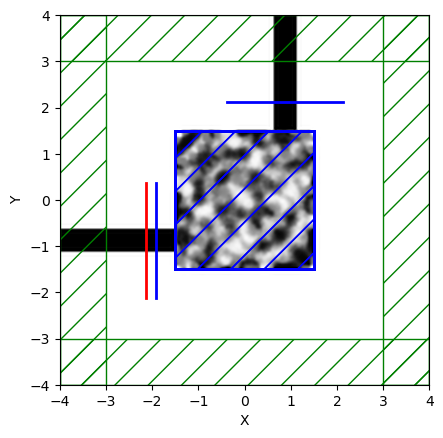

In [2]:
import gdsfactory as gf
import gdsfactory.simulation.gmeep as gm
import meep as mp
import meep.adjoint as mpa
import autograd.numpy as npa
import numpy as np
from autograd import  tensor_jacobian_product
from meep.adjoint import get_conic_radius_from_eta_e
import matplotlib as plt
import tidy3d

SiO2 = mp.Medium(index=1.45)
Si = mp.Medium(index=3.45)

radius = 2
c = gf.components.bend_circular(radius=radius)
c = c.move([-2.5,-2.5])

design_region_width = radius + 1
design_region_height = radius + 1

eta_e = 0.55
minimum_length = 0.1
filter_radius = get_conic_radius_from_eta_e(minimum_length, eta_e)
eta_i = 0.5
eta_d = 1 - eta_e

resolution = 20
design_region_resolution = int(5 * resolution)

Nx = int(design_region_resolution * design_region_width)
Ny = int(design_region_resolution * design_region_height)

pml_size = 1.0
extend_length = 3
waveguide_width = 0.5
Sx = 2 * pml_size + design_region_width + extend_length
Sy = 2 * pml_size + design_region_height + extend_length
cell_size = (Sx, Sy)

# define the design region
design_variables = mp.MaterialGrid(mp.Vector3(Nx, Ny), SiO2, Si, grid_type="U_MEAN")
design_region = mpa.DesignRegion(
    design_variables,
    volume=mp.Volume(
        center=mp.Vector3(),
        size=mp.Vector3(design_region_width, design_region_height, 0),
    ),
)

def mapping(x, eta, beta):
    # filter
    filtered_field = mpa.conic_filter(
        x,
        filter_radius,
        design_region_width,
        design_region_height,
        design_region_resolution,
    )

    # projection
    projected_field = mpa.tanh_projection(filtered_field, beta, eta)

    projected_field = (npa.rot90(projected_field.T, 2) + projected_field) / 2

    # interpolate to actual materials
    return projected_field.flatten()

# Initial guess
n = Nx * Ny  # number of parameters
seed = 240
np.random.seed(seed)
x0 = mapping(
    np.random.rand(n),
    eta_i,
    128,
)

def J(source, output):
    power = npa.abs(output / source) ** 2
    return npa.mean(power)

# Use function to get optimization problem
opt = gm.get_meep_adjoint_optimizer(
    c,
    J,
    [design_region],
    [design_variables],
    x0,
    resolution=resolution,
    cell_size=(
        Sx,
        Sy,
    ),
    tpml=1.0,
    extend_ports_length=extend_length,
    port_margin=1,
    port_source_offset=1,
    port_monitor_offset=1,
    wavelength_points=10,
)

evaluation_history = []
cur_iter = [0]

# Objective function
def f(v, gradient, cur_beta):
    print(f"Current iteration: {cur_iter[0] + 1}")

    f0, dJ_du = opt([mapping(v, eta_i, cur_beta)])

    plt.figure()
    ax = plt.gca()
    opt.plot2D(
        False,
        ax=ax,
        plot_sources_flag=False,
        plot_monitors_flag=False,
        plot_boundaries_flag=False,
    )
    plt.show()

    if gradient.size > 0:
        gradient[:] = tensor_jacobian_product(mapping, 0)(
            v, eta_i, cur_beta, np.sum(dJ_du, axis=1)
        )

    evaluation_history.append(np.max(np.real(f0)))

    cur_iter[0] = cur_iter[0] + 1

    return np.real(f0)

# Define spatial arrays used to generate bit masks
x_g = np.linspace(-design_region_width / 2 + 5, design_region_width / 2 + 5, Nx)
y_g = np.linspace(-design_region_height / 2, design_region_height / 2, Ny)
X_g, Y_g = np.meshgrid(x_g, y_g, sparse=True, indexing="ij")

# Define the core mask
left_wg_mask = (X_g == -design_region_width / 2 + 5) & (np.abs(Y_g) <= waveguide_width + 5)
top_wg_mask = (X_g <= (waveguide_width/2 + design_region_width / 2 + 5)) & (X_g >= waveguide_width/2 - design_region_width / 2 + 5) & (Y_g == design_region_height)

Si_mask = left_wg_mask | top_wg_mask

# Define the cladding mask
border_mask = (
    (X_g == -design_region_width / 2)
    | (X_g == design_region_width / 2)
    | (Y_g == -design_region_height / 2)
    | (Y_g == design_region_height / 2)
)
SiO2_mask = border_mask.copy()
SiO2_mask[Si_mask] = False

# Set masks for edges
x = np.ones((n,)) * 0.5
x[Si_mask.flatten()] = 1  # set the edges of waveguides to silicon
x[SiO2_mask.flatten()] = 0  # set the other edges to SiO2

# lower and upper bounds
lb = np.zeros((Nx * Ny,))
lb[Si_mask.flatten()] = 1
ub = np.ones((Nx * Ny,))
ub[SiO2_mask.flatten()] = 0

cur_beta = 4
beta_scale = 2
num_betas = 7
update_factor = 12
run_optimization = True

if run_optimization:
    for iters in range(num_betas):
        print("current beta: ", cur_beta)

        if iters != num_betas - 1:
            x[:] = gm.run_meep_adjoint_optimizer(
                n,
                lambda a, g: f(a, g, cur_beta),
                x,
                lower_bound=lb,
                upper_bound=ub,
                maxeval=update_factor,
            )
        else:
            optimized_component = gm.run_meep_adjoint_optimizer(
                n,
                lambda a, g: f(a, g, cur_beta),
                x,
                lower_bound=lb,
                upper_bound=ub,
                maxeval=update_factor,
                get_optimized_component=True,
                opt=opt,
                threshold_offset_from_max=0.09,
            )
        cur_beta = cur_beta * beta_scale

    optimized_component.plot()
    final_figure_of_merit = 10 * np.log10(
        0.5 * np.array(evaluation_history[-1])
    )